In [1]:
import numpy as np
import numpy.random as npr
import pandas as pd
import math
import scipy as sc
from scipy.stats import norm
import statsmodels.genmod.generalized_linear_model as st
from matplotlib import pyplot as plt
import statsmodels.tsa.ar_model as armodel

/Users/antoinegrelety/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


### Exercice 1

#### 1.Bootstraping ma1 et ar1

In [2]:
def AR_sim(p,phis,epsilon):
    n = len(epsilon)
    if (len(phis)!=p) :
        print("le vecteur de paramètres n'a pas la bonne dimension ")
    X = np.zeros(n)
    for j in np.arange((p),(n)):
        X[j] = -np.dot(phis,X[(j-p):(j)]) +  epsilon[j]
    return(X[(p):(n)])

def MA_sim(q,psis,epsilon):
    n = len(epsilon)
    if (len(psis)!=q):
        print("le vecteur de paramètres n'a pas la bonne dimension")
    X = np.zeros(n)
    for j in np.arange((q+1),(n)):
        X[j] =  epsilon[j] + np.dot(psis,epsilon[(j-q):(j)])
    return(X[(q+1):(n)])

In [3]:
def sample(ar1,B):
    list_B=[]
    n=len(ar1)
    for k in range((B)):
        ind=npr.randint(0,n,n)
        sample=ar1[ind]
        list_B.append(sample)
    return(list_B)

In [4]:
n=200
epsilon = np.random.exponential(1,n)-1
phis=np.array([-0.6])
p=1
ar1 = AR_sim(p,phis,epsilon)

In [5]:
n=200
epsilon = np.random.exponential(1,n)-1
q=1
psis=np.array([0.5])
ma1=MA_sim(q,psis,epsilon)

In [6]:
B=100
list_ar1_boot = sample(ar1,B)
list_ma1_boot = sample(ma1,B)

#### 2.Représentation des séries

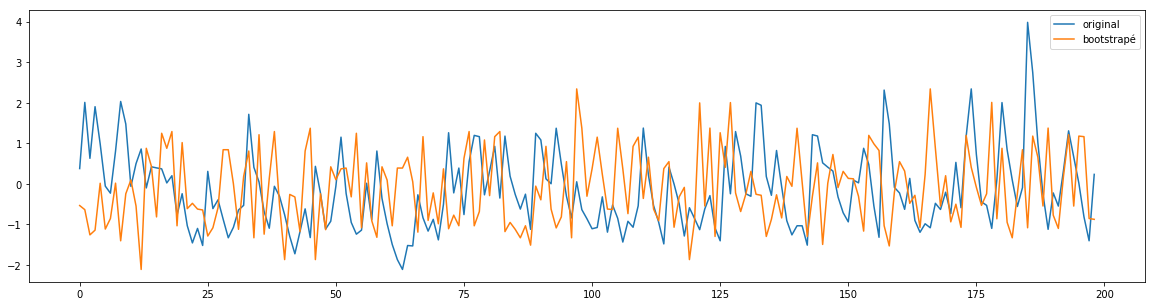

In [7]:
plt.figure(figsize=(20,5))
plt.plot(ar1)
plt.plot(list_ar1_boot[0])
plt.legend(['original','bootstrapé'])
plt.show()

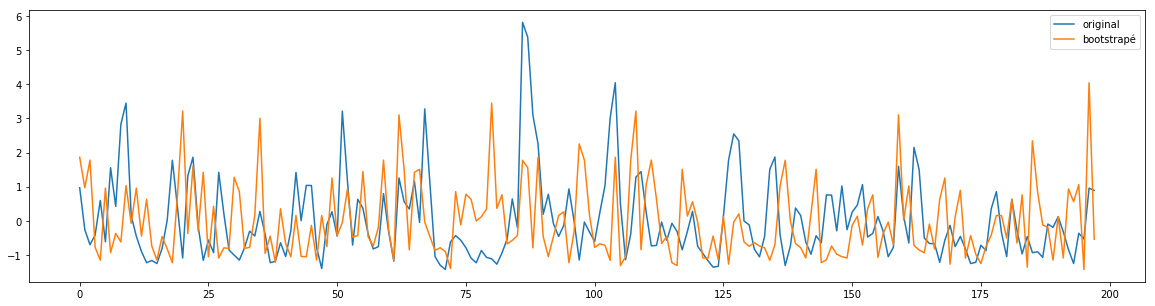

In [8]:
plt.figure(figsize=(20,5))
plt.plot(ma1)
plt.plot(list_ma1_boot[0])
plt.legend(['original','bootstrapé'])
plt.show()

#### 3. Limites de la méthode

Les échantillons bootstrapés n'ont pas la même distribution par rapport à l'échantillon initial. Le bootstraping classique ne suit donc pas le même processus aléatoire.

### Exercice 2

Génère un AR2 process

In [204]:
n=200
epsilon = np.random.exponential(1,n)-1
p=2
phis=npr.uniform(0,0.1,size=p)
ar1 = AR_sim(p,phis,epsilon)

In [202]:
def bootstrap_sieve(serie,B=100):
    serie_model = armodel.AR(serie)
    p=serie_model.select_order(maxlag=10,ic='aic')
    fitted_serie=serie_model.fit(maxlag=p)
    fitted_values_serie = fitted_serie.fittedvalues
    res_serie = fitted_serie.resid
    res_serie = res_serie - 1/(n-p)*np.sum([res_serie[i] for i in np.arange(0,n-(p+2))]) #recentre les résidus
    phi=fitted_serie.params[range(1,len(fitted_serie.params))]  #on exclue l'intercept
    Boots_list=[]
    for b in range(B):
        ind=npr.randint(p+1,len(serie)-(p+1),1)
        Xboot=[]
        for t in range(p+1,len(serie)-(p+1)):
            X=ar1[range(t-p,t)]
            Xboot.append(np.dot(phi,X.T)+fitted_serie.params[0]+res_serie[ind])
        Xboot = np.array(Xboot).flatten()
        Boots_list.append(Xboot)
    return(Boots_list)

#### 1. Estime $\hat{p}_{n}$ et les coef associés

In [55]:
ar1_model = armodel.AR(ar1)
p=ar1_model.select_order(maxlag=10,ic='aic')
print("Estimation de p_n: ",p)

fitted_ar1=ar1_model.fit(maxlag=p)
fitted_values_ar = fitted_ar1.fittedvalues

Estimation de p_n:  2


#### 2. Estime residus

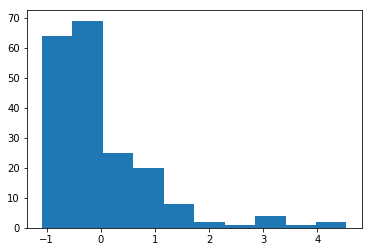

In [57]:
res_ar = fitted_ar1.resid
#recentre les résidus
res_ar = res_ar - 1/(n-p)*np.sum([res_ar[i] for i in np.arange(0,n-(p+2))])
plt.hist(res_ar)
plt.show()

On vérifie que les résidus sont bien centrés en 0

In [58]:
print(np.mean(res_ar))

9.063045098980869e-18


#### 3. Reconstruction de l'AR(p) process

In [59]:
B=100
phi=fitted_ar1.params[range(1,len(fitted_ar1.params))]  #on exclue l'intercept
Boots_list=[]
for b in range(B):
    #print(b)
    ind=npr.randint(p+1,len(ar1)-(p+1),1)
    Xboot=[]
    for t in range(p+1,len(ar1)-(p+1)):
        X=ar1[range(t-p,t)]
        Xboot.append(np.dot(phi,X.T)+fitted_ar1.params[0]+res_ar[ind])
    Boots_list.append(Xboot)

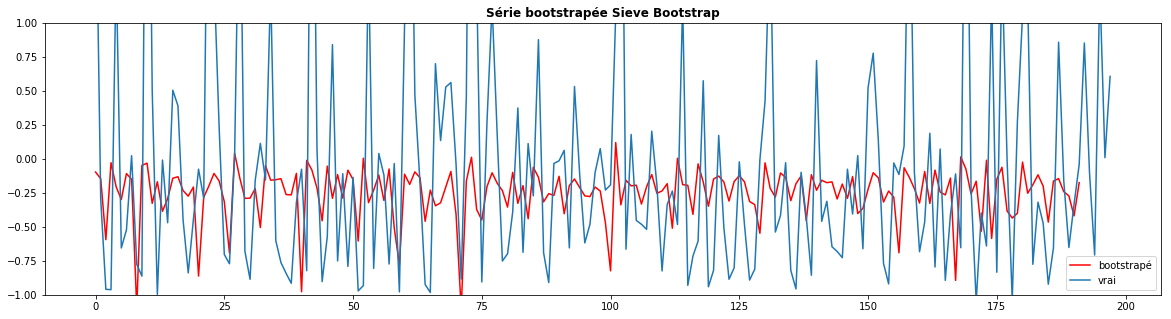

In [63]:
plt.figure(figsize=(20,5))
plt.title('Série bootstrapée Sieve Bootstrap',fontweight='bold')
plt.plot(Boots_list[0],color='red')
plt.plot(ar1)
plt.legend(['bootstrapé','vrai'])
plt.ylim(-1,1)
plt.show()

#### 2. Limites de la méthode

La série bootstrapée semble suivre les faibles variations de la série initiale et semble correcte en moyenne, cependant elle capture difficilement les grands écarts par rapport à la moyenne.

### Exercice 3

In [141]:
def bootstrap_block(l,serie,B=100):
    # 1. et 2. Circulariser la série et définir l, N
    N=int(np.floor(n/l))
    #circularise la série
    X_circle = np.zeros(N*n)
    t=0
    for i in range(N*n):
        X_circle[i] = serie[t]
        t=t+1
        if(t==len(serie)):
            t=0
    # Etape 3: bootstraping
    Boots_list_block=[]
    for b in range(B):
        concat_X=[]
        for j in range(N):
            #(a) tire avec remise
            v_bk = ind=npr.randint(0,N,1)
            #(b) crée des blocs
            X_vb = X_circle[np.arange(v_bk,v_bk+l)]
            concat_X.append(X_vb)
        concat_X=np.array(concat_X).flatten()
        Boots_list_block.append(concat_X)
    return(Boots_list_block)

In [142]:
Boots_list_block = bootstrap_block(l=5,serie=ma1)

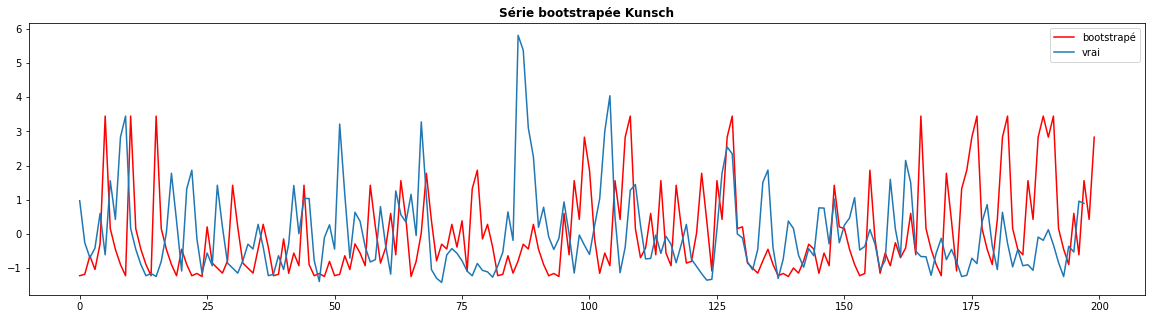

In [144]:
plt.figure(figsize=(20,5))
plt.title('Série bootstrapée Kunsch',fontweight='bold')
plt.plot(Boots_list_block[1],color='red')
plt.plot(ma1)
plt.legend(['bootstrapé','vrai'])

plt.show()

#### Limites de la méthode

Contrairement à la méthode précédente, cette série semble bien capturer l'amplitude de la série originale. Cependant, cette méthode dépend d'un découpage arbitraire en blocs de taille l. Ce type de découpage risque d'interférer avec les périodes de saisonalité.

### Exercice 4

In [183]:
def bootstrap_PR(l,serie,B=100):
    N=int(np.floor(n/l))
    #circularise la série
    X_circle = np.zeros(N*n)
    t=0
    for i in range(N*n):
        X_circle[i] = serie[t]
        t=t+1
        if(t==len(serie)):
            t=0
    Boots_list_PR=[]
    for b in range(B):
        concat_X=[]
        for j in range(N):
            #(a) tire avec remise
            v_bk = ind=npr.randint(0,N,1)
            #(b) crée des blocs
            l_geom = npr.geometric(1/l)
            while l_geom > n-1:
                l_geom = npr.geometric(1/l)
            X_vb = list(X_circle[np.arange(v_bk,v_bk+l_geom)])
            concat_X=concat_X+X_vb
        #concat_X=np.array(concat_X).flatten()
        Boots_list_PR.append(concat_X)
    return(Boots_list_PR)

In [184]:
Boots_list_PR = bootstrap_PR(l=5,serie=ma1)

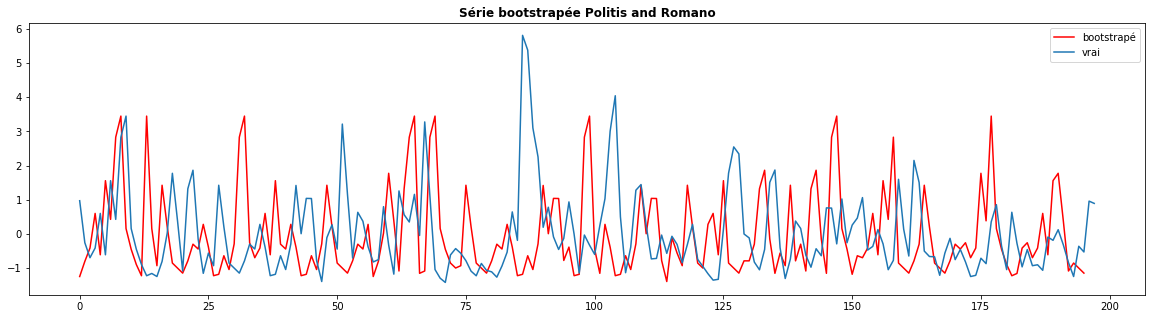

In [185]:
plt.figure(figsize=(20,5))
plt.title('Série bootstrapée Politis and Romano',fontweight='bold')
plt.plot(Boots_list_PR[2],color='red')
plt.plot(ma1)
plt.legend(['bootstrapé','vrai'])
plt.show()

### Exercice 5

In [186]:
import statsmodels.tsa.stattools as stat_ts

In [187]:
def var_boot(rho):
    B=len(rho)
    sum1=np.mean(rho)
    return( (1/B*np.sum(rho-np.ones(B)*sum1))**2 )

In [193]:
list_var_block=[]
list_var_PR=[]
for l in range(1,100):
    rho2_block_list=[]
    rho2_PR_list=[]
    Boots_list_block = bootstrap_block(l,ma1)
    Boots_list_PR = bootstrap_PR(l,ma1)
    for b in range(len(Boots_list_block)):
        rho2_block_list.append( stat_ts.acf(Boots_list_block[b])[2] )
        rho2_PR_list.append( stat_ts.acf(Boots_list_PR[b])[2] )
    list_var_block.append(var_boot(rho2_block_list))
    list_var_PR.append(var_boot(rho2_PR_list))

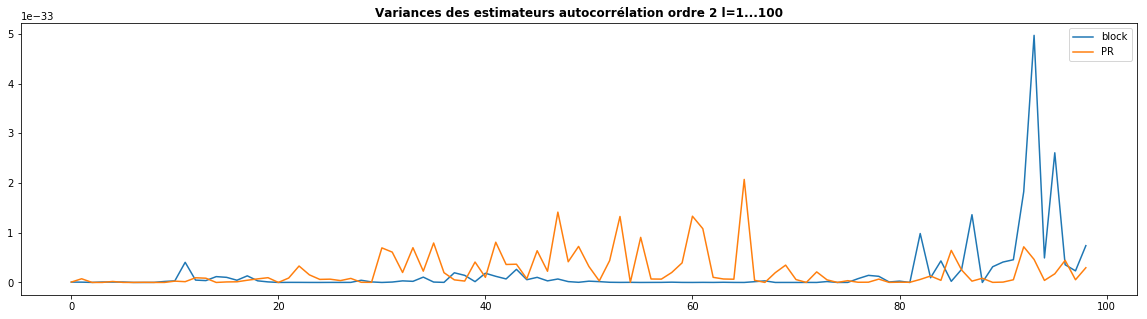

In [194]:
plt.figure(figsize=(20,5))
plt.title('Variances des estimateurs autocorrélation ordre 2 l=1...100',fontweight='bold')
plt.plot(list_var_block)
plt.plot(list_var_PR)
plt.legend(['block','PR'])
plt.show()

La variance du coefficient d'autocorrélation d'ordre 2 semble prendre occasionellement des valeurs élevées lorsque l augmente. En d'autres termes, lorsque la taille des blocs diminue, les coefficients bootstrapés se dispersent davantage. Cette observation est vraie pour les deux méthodes. On remarque cependant que lorsque l est proche de 100, la variance pour la méthode block prend des valeurs très élevées. Pour la méthode PR, on génère des blocs de taille aléatoire, ce qui permet des tailles de blocs parfois plus importantes et donc une variance réduite.

### Exercice 6

In [209]:
B=50
list_boot_sieve = bootstrap_sieve(ar1,B=B)
list_boot_block = bootstrap_block(l=5,serie=ar1,B=B)
list_boot_PR = bootstrap_PR(l=5,serie=ar1,B=B)

p_sieve=[]
p_block=[]
p_PR=[]
for i in range(B):
    #ordre p méthode Sieve
    ar1_model = armodel.AR(list_boot_sieve[i])
    p_sieve.append(ar1_model.select_order(maxlag=10,ic='aic'))
    #ordre p méthode block
    ar1_model = armodel.AR(list_boot_block[i])
    p_block.append(ar1_model.select_order(maxlag=10,ic='aic'))
    #ordre p méthode Sieve
    ar1_model = armodel.AR(list_boot_PR[i])
    p_PR.append(ar1_model.select_order(maxlag=10,ic='aic'))

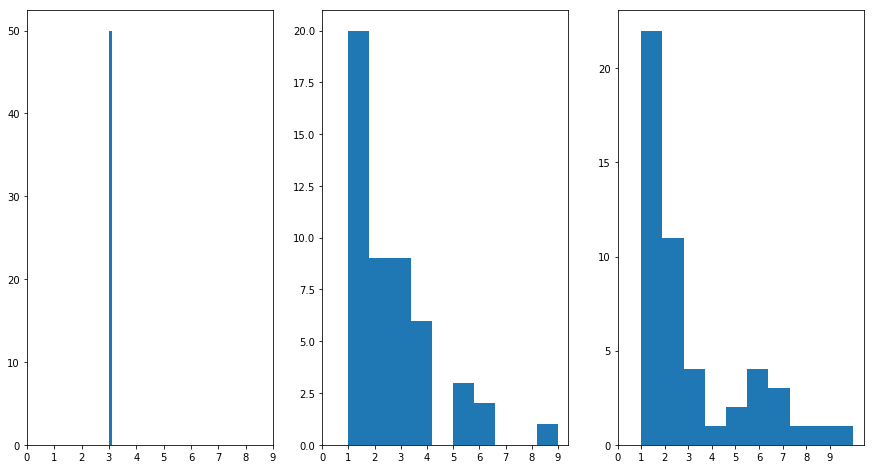

In [216]:
fig = plt.figure(figsize=(15,8))

plt.subplot(131)
plt.hist(p_sieve)
plt.xticks(np.arange(0,10))
plt.subplot(132)
plt.hist(p_block)
plt.xticks(np.arange(0,10))
plt.subplot(133)
plt.hist(p_PR)
plt.xticks(np.arange(0,10))

plt.show()